#**Recommendation System Assignment**

###**Data Description:**
- Unique ID of each anime.
- Anime title.
- Anime broadcast type, such as TV, OVA, etc.
anime genre.
- The number of episodes of each anime.
- The average rating for each anime compared to the number of users who gave ratings.

###**Number of community members for each anime.**
**Objective:**

The objective of this assignment is to implement a recommendation system using cosine similarity on an anime dataset.
- **Dataset:**
Use the Anime Dataset which contains information about various anime, including their titles, genres,No.of episodes and user ratings etc.

##**Tasks:**
1. **Data Preprocessing:**
- Load the dataset into a suitable data structure (e.g., pandas DataFrame).
Handle missing values, if any.
- Explore the dataset to understand its structure and attributes.

2. **Feature Extraction:**
- Decide on the features that will be used for computing similarity (e.g., genres, user ratings).
- Convert categorical features into numerical representations if necessary.
- Normalize numerical features if required.

3. **Recommendation System:**
- Design a function to recommend anime based on cosine similarity.
- Given a target anime, recommend a list of similar anime based on cosine similarity scores.
- Experiment with different threshold values for similarity scores to adjust the recommendation list size.

4. **Evaluation:**
- Split the dataset into training and testing sets.
- Evaluate the recommendation system using appropriate metrics such as precision, recall, and F1-score.
- Analyze the performance of the recommendation system and identify areas of improvement.




**Predicting Rating:**

- **Target Variable:** rating
- **Independent Variables:** genre, type, episodes, possibly members

In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
# Load the dataset
file_path = r'/content/anime.csv'
anime_df = pd.read_csv(file_path)

In [3]:
# Display the first few rows of the dataset
anime_df.head()

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

#**1. Data Preprocessing**

In [4]:
anime_df.shape

(12294, 7)

In [5]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
#Summary Statistics
anime_df.describe()

anime_id        rating       members
count  12294.000000  12064.000000  1.229400e+04
mean   14058.221653      6.473902  1.807134e+04
std    11455.294701      1.026746  5.482068e+04
min        1.000000      1.670000  5.000000e+00
25%     3484.250000      5.880000  2.250000e+02
50%    10260.500000      6.570000  1.550000e+03
75%    24794.500000      7.180000  9.437000e+03
max    34527.000000     10.000000  1.013917e+06

In [7]:
# Check for missing values
print(anime_df.isnull().sum())

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


In [8]:
# Handle missing values (example: fill with median or drop)
numeric_columns = anime_df.select_dtypes(include=['number']).columns
anime_df[numeric_columns] = anime_df[numeric_columns].fillna(anime_df[numeric_columns].median())


In [9]:
#  drop missing values
anime_df = anime_df.dropna()

In [10]:
print(anime_df.isnull().sum())

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


In [11]:
#datatypes
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [12]:
#Typecasting
anime_df['name'] = anime_df['name'].astype('category')
anime_df['genre'] = anime_df['genre'].astype('category')
anime_df['type'] = anime_df['type'].astype('category')
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')  # Handle non-numeric entries
# Fill any remaining NaN values in 'episodes' with a suitable value (e.g., 0)
anime_df['episodes'] = anime_df['episodes'].fillna(0)
anime_df['episodes'] = anime_df['episodes'].astype('int64')

In [13]:
anime_df.dtypes

anime_id       int64
name        category
genre       category
type        category
episodes       int64
rating       float64
members        int64
dtype: object

In [14]:
#number of columns
anime_df.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

In [15]:
#numerical columns
anime_numeric_columns = anime_df.select_dtypes(include=['int64','float64']).columns
outliers = {}

for col in anime_numeric_columns:
    Q1 = np.quantile(anime_df[col], 0.25) # Index the DataFrame 'anime_df' using the column name
    Q3 = np.quantile(anime_df[col], 0.75) # Index the DataFrame 'anime_df' using the column name
    IQR = (Q3 - Q1)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = anime_df[(anime_df[col] < lower_bound) | (anime_df[col] > upper_bound)][col]

In [16]:
# Print the outliers
for col, values in outliers.items():
    if not values.empty:
        print(f"Outliers in {col}:\n{values}\n")
    else:
        print(f"No outliers in {col}\n")

No outliers in anime_id

Outliers in episodes:
1         64
2         51
4         51
6        148
7        110
        ... 
10879     64
10880     63
10882     52
10895     32
11486     38
Name: episodes, Length: 1122, dtype: int64

Outliers in rating:
0        9.37
1        9.26
2        9.25
3        9.17
4        9.16
         ... 
12263    3.11
12268    2.86
12270    3.00
12275    3.14
12278    3.61
Name: rating, Length: 247, dtype: float64

Outliers in members:
0        200630
1        793665
2        114262
3        673572
4        151266
          ...  
11530     28620
11566     37519
12209     29463
12213     27411
12217     57355
Name: members, Length: 1887, dtype: int64



In [17]:
#Function to cap outliers:
def cap_outliers_iqr(anime_df, column):
    """
    Cap outliers in a DataFrame column using the IQR method.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column in which to cap outliers.

    Returns:
    pd.DataFrame: A DataFrame with outliers capped.
    """
    Q1 = anime_df[column].quantile(0.25)
    Q3 = anime_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    anime_df[column] = anime_df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return anime_df


In [18]:
# Capping outliers in 'episodes', 'rating', and 'members'
anime_df = cap_outliers_iqr(anime_df, 'episodes')
anime_df = cap_outliers_iqr(anime_df, 'rating')
anime_df = cap_outliers_iqr(anime_df, 'members')

# Verify the changes
print(anime_df.describe())


           anime_id      episodes        rating       members
count  12210.000000  12210.000000  12210.000000  12210.000000
mean   13936.486486      7.536446      6.488588   6336.902252
std    11398.045316      9.705196      0.988597   8652.393973
min        1.000000      0.000000      3.995000      5.000000
25%     3460.250000      1.000000      5.900000    229.000000
50%    10168.500000      2.000000      6.570000   1571.000000
75%    24442.500000     12.000000      7.170000   9530.000000
max    34527.000000     28.500000      9.075000  23481.500000


#**Data Visualisation**

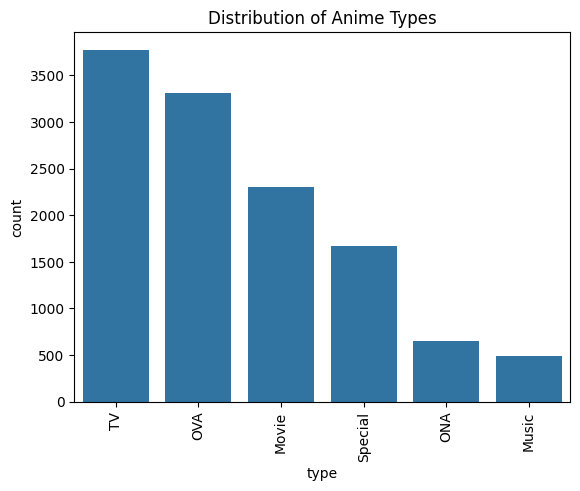

In [19]:
#univariate categorical columns
sns.countplot(x='type', data=anime_df, order=anime_df['type'].value_counts(ascending= False).index) # Sort bars by count in ascending order
plt.title('Distribution of Anime Types')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability if needed
plt.show()

- **TV:** The most common type of anime, with the highest count.
- **OVA (Original Video Animation):** The second most common type.
- **Movie:** The third most common type.
- **Special:** Less common than TV, OVA, and Movie.
- **ONA (Original Net Animation):** Relatively uncommon.
- **Music:** The least common type.

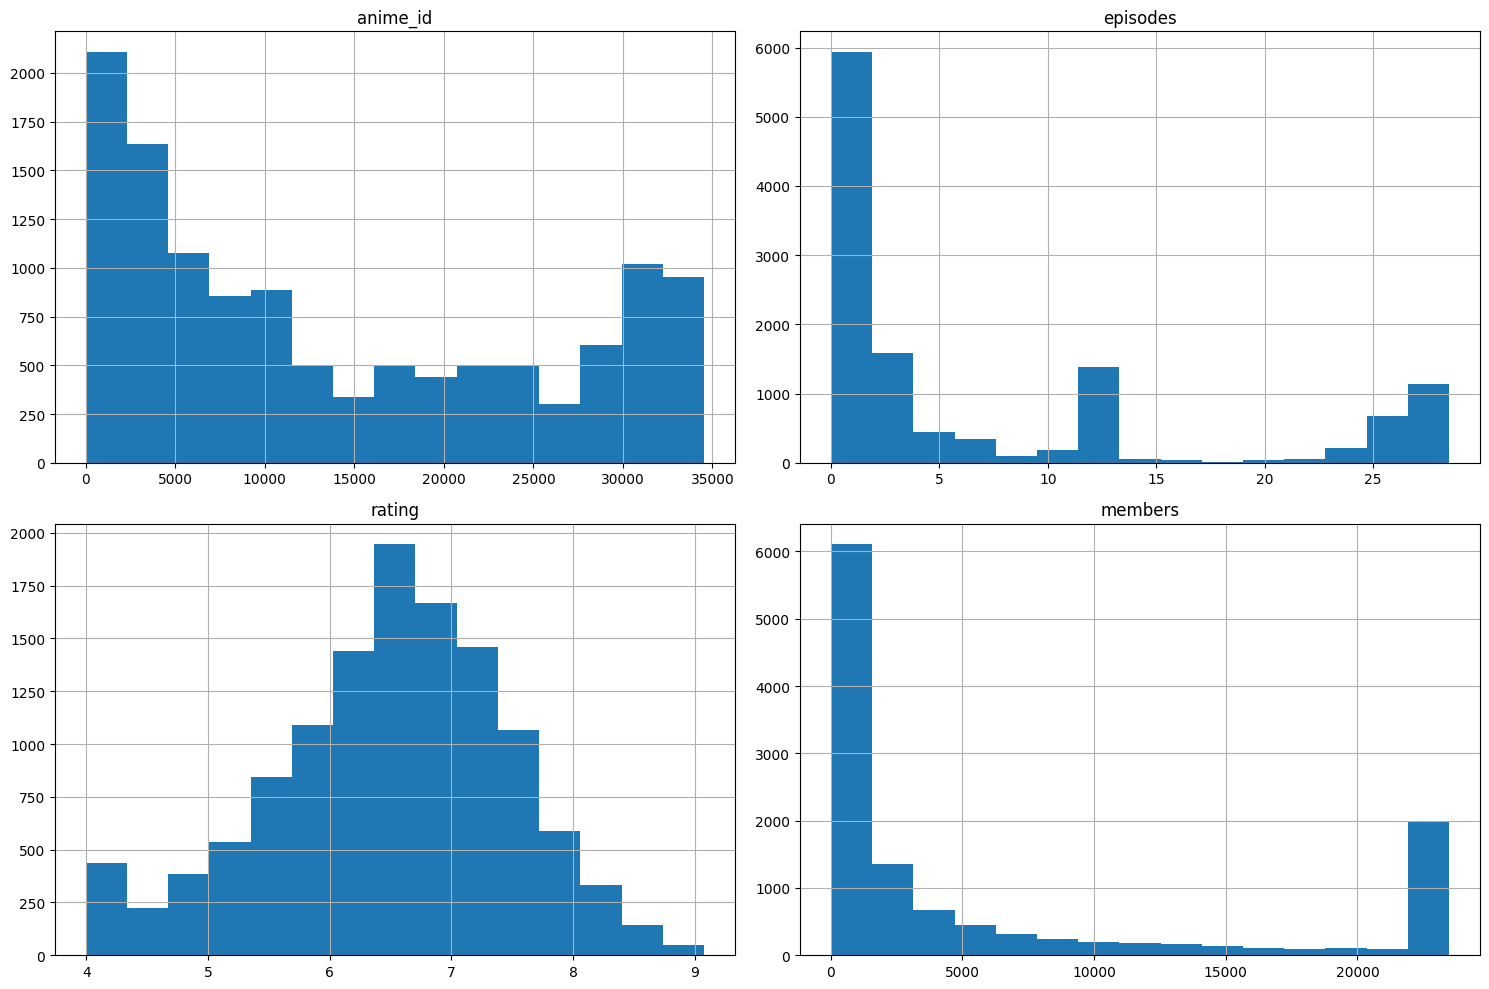

In [20]:
# Histograms
anime_df.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

- **anime_id:** The distribution of anime IDs appears to be somewhat bimodal.
- **episodes:** The number of episodes has a highly skewed distribution.
- **rating:** The ratings distribution appears to be approximately normal, centered around 7. This suggests that most anime have ratings around this value, with fewer anime having very low or very high ratings.
- **members:** The distribution of members is also highly skewed.

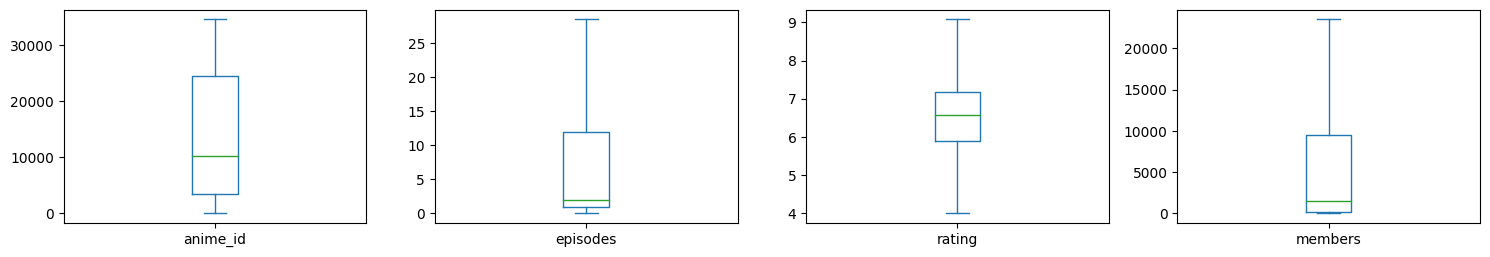

In [21]:
# Box plots
anime_df.plot(kind='box', subplots=True, layout=(4,4), figsize=(15, 10), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

**No outliers**

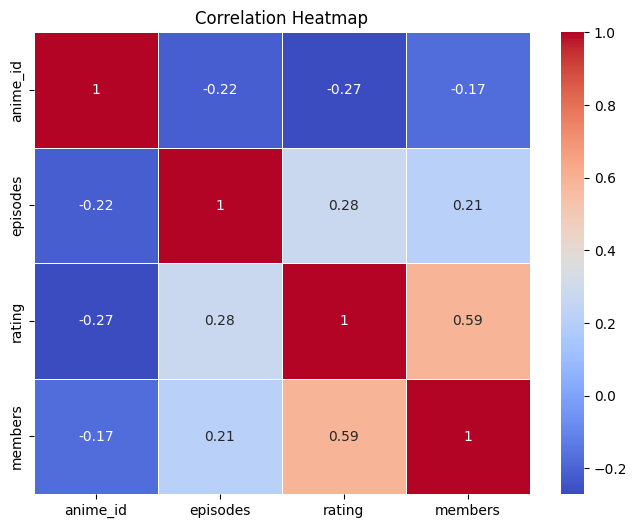

In [22]:
#Correlation Heatmap
correlation_matrix = anime_df.select_dtypes(include=['number']).corr() # Select only numerical columns
fig, ax = plt.subplots(figsize=(8, 6))  # Create a new figure and axes
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
ax.set_title('Correlation Heatmap')
plt.show()

- **rating and members** are suitable target variables, with members showing a stronger relationship with other variables.
- **episodes** shows weak but **positive relationships** with both **rating** and **members**, making it a useful independent variable.
- **anime_id** should be excluded from predictive modeling as it does not provide meaningful information.
episodes:

Weak positive correlations with rating (0.28) and members (0.21). This indicates that the number of episodes has a slight positive relationship with both the rating and the number of members.
rating:

Moderate positive correlation with members (0.59). This suggests that higher-rated anime tend to have more members, indicating a stronger relationship compared to other variables.

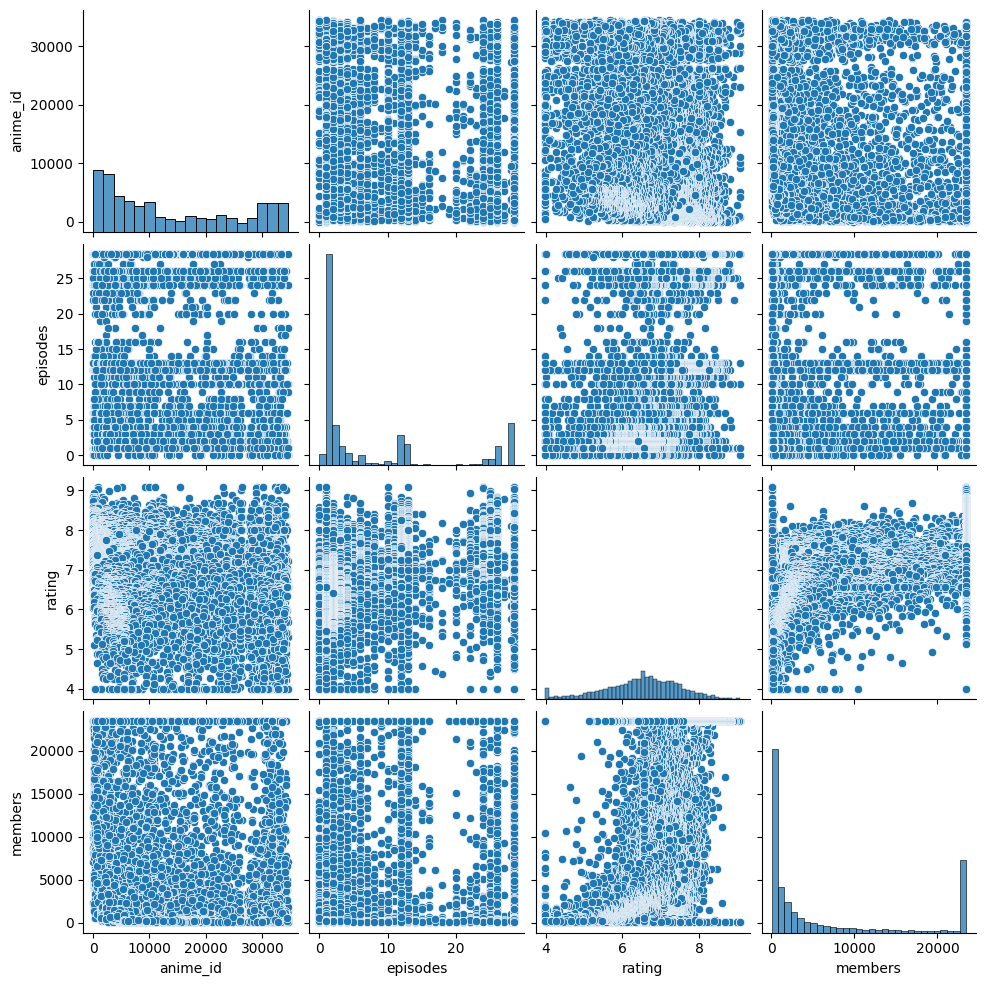

In [23]:
# checking relation between the pair for variables
sns.pairplot(anime_df)

- **rating and members** show notable relationships, with members being influenced more by rating.
- **episodes** has a weak positive correlation with both rating and members, making it a less powerful predictor.
- **anime_id** should not be used as a predictor due to its lack of correlation with other variables.

#**2. Feature extraction:**

In [24]:
# Convert categorical features into numerical representations
genres_one_hot = anime_df['genre'].str.get_dummies(sep=', ')

In [25]:
# Normalize numerical features if required
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [26]:
numerical_features = ['rating', 'episodes', 'members']
anime_df[numerical_features] = scaler.fit_transform(anime_df[numerical_features])

In [27]:
print(anime_df[numerical_features].head())

     rating  episodes   members
0  2.616352 -0.673527  1.981567
1  2.616352  2.160123  1.981567
2  2.616352  2.160123  1.981567
3  2.616352  1.696434  1.981567
4  2.616352  2.160123  1.981567


**3. Recommendation system using cosine similarity:**

In [28]:
#Without setting any specific threshold values
# Example function to recommend anime
def recommend_anime_1(anime_title, anime_df, top_n=10):
    # Select only numerical features for similarity calculation
    numerical_features = ['rating', 'episodes', 'members']

    # Calculate cosine similarity using only numerical features
    cosine_sim = cosine_similarity(anime_df[numerical_features])

    indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()

    # Get the index of the anime that matches the title
    idx = indices[anime_title]

    # Get the pairwise similarity scores of all animes with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the animes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top n most similar animes
    sim_scores = sim_scores[1:top_n+1]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top n most similar animes
    return anime_df['name'].iloc[anime_indices]

In [29]:
# Single title
print(recommend_anime_1('Kimi no Na wa.', anime_df, top_n=10))

8       Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
11                                         Koe no Katachi
1987                                 Shaman King Specials
15                          Sen to Chihiro no Kamikakushi
18                           Ookami Kodomo no Ame to Yuki
24                                          Mononoke Hime
25                          Suzumiya Haruhi no Shoushitsu
2266                 Jinrui wa Suitai Shimashita Specials
710                         Hetalia World Series Specials
33                    Mushishi Zoku Shou: Suzu no Shizuku
Name: name, dtype: category
Categories (12208, object): ['&quot;0&quot;', '&quot;Aesop&quot; no Ohanashi yori: Ushi to K...,
                             '&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Ha..., '&quot;Bungaku Shoujo&quot; Memoire', ...,
                             'xxxHOLiC Shunmuki', 'Üks Uks', 'ēlDLIVE', '◯']


In [32]:
# Prompt user for input titles
print("Enter the anime titles for evaluation (separated by commas):")
user_input = input().split(',')
name_titles = [title.strip() for title in user_input]
#name_titles = ["Naruto", "One Piece"]
for name_title in name_titles:
    print(recommend_anime_1(name_title, anime_df, top_n=10))

Enter the anime titles for evaluation (separated by commas):
One Piece
165            Detective Conan Movie 13: The Raven Chaser
227     Detective Conan Movie 14: The Lost Ship in the...
279                      Hajime no Ippo: Boxer no Kobushi
3665                   Shinmai Maou no Testament Specials
1107        Mahou Sensei Negima! Shiroki Tsubasa Ala Alba
1099                                             Ajin OVA
81                              Girls und Panzer der Film
85                     Mushishi Zoku Shou: Odoro no Michi
89                                     Doukyuusei (Movie)
90                  Evangelion: 2.0 You Can (Not) Advance
Name: name, dtype: category
Categories (12208, object): ['&quot;0&quot;', '&quot;Aesop&quot; no Ohanashi yori: Ushi to K...,
                             '&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Ha..., '&quot;Bungaku Shoujo&quot; Memoire', ...,
                             'xxxHOLiC Shunmuki', 'Üks Uks', 'ēlDLIVE', '◯']


In [33]:

anime_features = pd.concat([anime_df[['anime_id', 'name', 'type', 'episodes', 'rating', 'members']], genres_one_hot], axis=1)

In [34]:
#Modified code
#Using threshold values
def recommend_anime_2(anime_name, anime_features, threshold=0.5, n_recommendations=5):
    # Select only numerical features for similarity calculation
    numerical_features = ['rating', 'episodes', 'members']

    # Calculate cosine similarity using only numerical features
    cosine_sim = cosine_similarity(anime_features[numerical_features])

    indices = pd.Series(anime_features.index, index=anime_features['name']).drop_duplicates()

    # Get the index of the anime that matches the title
    idx = indices[anime_name]

    # Get the similarity scores for the chosen anime
    similarity_scores = list(enumerate(cosine_sim[idx]))

    # Filter out recommendations below the threshold
    sim_scores = [score for score in similarity_scores if score[1] >= threshold]

    # Sort by similarity scores and get the top n recommendations
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_recommendations+1]

    # Get the recommended anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top n most similar animes
    return anime_features['name'].iloc[anime_indices]

In [35]:
# List of different threshold values to experiment with
threshold_values = [0.3, 0.5, 0.7, 0.9]

# Example usage with different thresholds
for threshold in threshold_values:
    print(f"Recommendations for threshold {threshold}:")
    recommendations = recommend_anime_2('Kimi no Na wa.', anime_features, threshold, 5)
    print(recommendations)
    print("\n")


Recommendations for threshold 0.3:
8       Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
11                                         Koe no Katachi
1987                                 Shaman King Specials
15                          Sen to Chihiro no Kamikakushi
18                           Ookami Kodomo no Ame to Yuki
Name: name, dtype: category
Categories (12208, object): ['&quot;0&quot;', '&quot;Aesop&quot; no Ohanashi yori: Ushi to K...,
                             '&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Ha..., '&quot;Bungaku Shoujo&quot; Memoire', ...,
                             'xxxHOLiC Shunmuki', 'Üks Uks', 'ēlDLIVE', '◯']


Recommendations for threshold 0.5:
8       Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
11                                         Koe no Katachi
1987                                 Shaman King Specials
15                          Sen to Chihiro no Kamikakushi
18                           Ookami Kodomo no Ame to Yuki
Name: name, dtype: cate

#**Evaluation:**

In [56]:
def evaluate_recommendation_system1(anime_titles, true_recommendations, anime_df, top_n=10):
    predicted_recommendations = []
    true_labels = []

    for i, title in enumerate(anime_titles):
        # Generate recommendations
        try:
            recommended_anime = recommend_anime_1(title, anime_df, top_n)
            recommended_set = set(recommended_anime)
        except ValueError:
            # If the anime title is not found, skip this iteration
            continue

        # Compare to true labels
        true_set = set(true_recommendations[i])

        # Create binary labels
        predicted_labels = [1 if anime in recommended_set else 0 for anime in anime_df['name']]
        true_binary_labels = [1 if anime in true_set else 0 for anime in anime_df['name']]

        predicted_recommendations.extend(predicted_labels)
        true_labels.extend(true_binary_labels)

    # Calculate metrics
    precision = precision_score(true_labels, predicted_recommendations)
    recall = recall_score(true_labels, predicted_recommendations)
    f1 = f1_score(true_labels, predicted_recommendations)
    accuracy = accuracy_score(true_labels, predicted_recommendations)

    return precision, recall, f1, accuracy

In [57]:
# Example usage
anime_titles = ["Naruto", "One Piece","Tokyo Ghoul"]
true_recommendations = [["Naruto Shippuden", "Bleach", "Dragon Ball Z"],
                        ["Fairy Tail", "Hunter x Hunter", "Naruto"],
                        ["Fullmetal Alchemist: Brotherhood", "Tokyo Ghoul", "Sword Art Online"] ]
precision, recall, f1, accuracy = evaluate_recommendation_system1(anime_titles, true_recommendations, anime_df, top_n=10)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, Accuracy: {accuracy}")

Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.998962598962599


#**Spiliting the dataset**

In [65]:
def recommend_anime(anime_title, anime_df, top_n=10, threshold=0.0):
    if anime_title not in anime_df['name'].values:
        return []  # Return an empty list if the anime title is not found1

    numerical_features = ['rating', 'episodes', 'members']
    cosine_sim = cosine_similarity(anime_df[numerical_features])

    indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()
    idx = indices[anime_title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Filter recommendations based on threshold
    sim_scores = [score for score in sim_scores if score[1] >= threshold]

    # Get the top_n most similar animes, respecting the threshold
    sim_scores = sim_scores[1:top_n+1]  # Skip the first one as it is the same anime

    anime_indices = [i[0] for i in sim_scores]
    return anime_df['name'].iloc[anime_indices].reset_index(drop=True)



In [66]:
def evaluate_recommendation_system(test_titles, true_recommendations, train_df, test_df, top_n=10, threshold=0.0):
    predicted_recommendations = []
    true_labels = []

    for i, title in enumerate(test_titles):
        recommended_anime = recommend_anime(title, train_df, top_n,threshold = threshold)
        recommended_set = set(recommended_anime)

        true_set = set(true_recommendations[i])

        predicted_labels = [1 if anime in recommended_set else 0 for anime in test_df['name']]
        true_binary_labels = [1 if anime in true_set else 0 for anime in test_df['name']]

        predicted_recommendations.extend(predicted_labels)
        true_labels.extend(true_binary_labels)

        # Debug information
        print(f"Title: {title}")
        print(f"Recommended: {recommended_set}")
        print(f"True: {true_set}")
        print(f"Predicted labels: {predicted_labels[:10]}")
        print(f"True labels: {true_binary_labels[:10]}\n")

    precision = precision_score(true_labels, predicted_recommendations)
    recall = recall_score(true_labels, predicted_recommendations)
    f1 = f1_score(true_labels, predicted_recommendations)
    accuracy = accuracy_score(true_labels, predicted_recommendations)

    return precision, recall, f1, accuracy

In [67]:
# Split the dataset
train_df, test_df = train_test_split(anime_df, test_size=0.2, random_state=42)

In [68]:
# Get test titles and true recommendations (For the sake of example, assuming each anime in test_df is the test title)
test_titles = test_df['name'].tolist()
true_recommendations = [test_df['name'].sample(n=3).tolist() for _ in test_titles]  # Replace with your actual true recommendations

# Evaluate the recommendation system
precision, recall, f1, accuracy = evaluate_recommendation_system(test_titles, true_recommendations, train_df, test_df, top_n=10,threshold=0.9)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, Accuracy: {accuracy}")

Streaming output truncated to the last 5000 lines.

Title: Bloody Date
Recommended: set()
True: {'Kai Douryoku', 'Rerere no Tensai Bakabon', 'Meiji Ishin wo Tsukuriageta Hitobito'}
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Title: Getter Robo
Recommended: set()
True: {'Konchuu Monogatari Minashigo Hutch', 'Eromanga-sensei', 'Vassalord.'}
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Title: Agukaru
Recommended: set()
True: {'Bad Boys', 'Kimama ni Idol', 'Digimon Adventure tri. 3: Kokuhaku'}
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Title: Pororo Geugjangpan Super Sseolmae Daemoheom
Recommended: set()
True: {'Akuma-kun', 'Hana no Kage', 'Rokushin Gattai GodMars: Juunanasai no Densetsu'}
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Title: Ojiisan no Lamp
Recommended: set()
True: {'Tengai Maky

In [69]:
# Prompt user for input titles
print("Enter the anime titles for evaluation (separated by commas):")
user_input = input().split(',')
test_titles = [title.strip() for title in user_input]

# Ensure all titles exist in the test set
valid_titles = [title for title in test_titles if title in test_df['name'].values]
if len(valid_titles) < len(test_titles):
    print("Some titles were not found in the test set and will be ignored.")

# Generate or provide true recommendations for the input titles
# For simplicity, we will assume the true recommendations are randomly selected from the test set
true_recommendations = [test_df['name'].sample(n=3).tolist() for _ in valid_titles]  # Replace with your actual true recommendations

#For different threshold values
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in thresholds:
    # Evaluate the recommendation system
    precision, recall, f1, accuracy = evaluate_recommendation_system(valid_titles, true_recommendations, train_df, test_df, top_n=10,threshold = threshold )
    print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}, Accuracy: {accuracy}")


Enter the anime titles for evaluation (separated by commas):
The TV Show
Title: The TV Show
Recommended: set()
True: {'Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari', 'Santa Company', 'Tantei Opera Milky Holmes Movie: Gyakushuu no Milky Holmes'}
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.9987714987714987
Title: The TV Show
Recommended: set()
True: {'Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari', 'Santa Company', 'Tantei Opera Milky Holmes Movie: Gyakushuu no Milky Holmes'}
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.9987714987714987
Title: The TV Show
Recommended: set()
True: {'Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari', 'Santa Company', 'Tantei Opera Milky Holmes Movie: Gyakushuu no Milky Holmes'}
Predicted labels: [0, 0, 0, 0, 0, 0

**The recommendation system evaluated has an exceptionally high accuracy of approximately 99.88%, but the precision, recall, and F1 score are all 0.0. This situation indicates that the model is not performing well in distinguishing between classes, specifically the positive class.**

#**Analysis**

**1.High Accuracy, Low Precision and Recall**

**2.Class Imbalance**
The most likely issue is a class imbalance, where the positive class (the class of interest) is very rare compared to the negative class. The model might be biased toward predicting the majority class.

**3.Model Threshold**
The default threshold for classifying positives and negatives might not be suitable. The model could be predicting all instances as the negative class due to an inappropriate threshold.

**4.Feature Representation** e
The features used to train the model might not be effectively capturing the patterns of the positive class, leading to poor performance in identifying it.


#**Areas of Improvement**

**Handle Class Imbalance:**
- Resampling Techniques: Use oversampling (e.g., SMOTE) or undersampling to balance the dataset.
- Class Weights: Adjust the class weights to make the model pay more attention to the minority class.

**Adjust Decision Threshold:**
- Threshold Tuning: Experiment with different thresholds for classifying positives and negatives to find a balance that improves precision and recall.

**Model Evaluation:**
- Evaluation Metrics: Use precision, recall, and F1 score as primary metrics for evaluation, especially in cases of class imbalance.
- Confusion Matrix: Analyze the confusion matrix to understand the distribution of predictions and misclassifications.

**Feature Engineering:**
- Feature Selection: Ensure relevant features are included that help in distinguishing between classes.
- Feature Transformation: Apply techniques like normalization, encoding, or creating interaction features that might improve model performance.

**Model Choice and Tuning:**
- Algorithm Choice: Experiment with different algorithms that might handle class imbalance better (e.g., ensemble methods, anomaly detection).
- Hyperparameter Tuning: Tune hyperparameters to better fit the minority class.




#**Interview Questions:**

#**1. Can you explain the difference between user-based and item-based collaborative filtering?**


###**User-Based Collaborative Filtering**

**Focus: Similar users**

**Process:**
- Identify similar users: Calculate the similarity between users based on their ratings or behaviors (e.g., purchasing history, movie ratings).
- Recommendation generation: Recommend items that similar users have liked but the target user has not yet experienced.

**Steps:**
- User-Item Matrix: Create a matrix where rows represent users and columns represent items, with each cell containing the user's rating for the item.
- Similarity Calculation: Use similarity measures (like cosine similarity, Pearson correlation, etc.) to find users similar to the target user.
- Predict Ratings: Predict the target user’s rating for an item by aggregating the ratings of similar users for that item, often using a weighted sum based on similarity scores.
- Recommend Items: Recommend items with the highest predicted ratings to the target user.

**Advantages:**
- Can provide personalized recommendations.
- Effective in domains where user preferences are diverse.

**Disadvantages:**
- Scalability issues as the number of users grows.
- Sparsity problem: Many users may have rated only a few items, making it harder to find similar users.



###**Item-Based Collaborative Filtering**

**Focus: Similar items**

**Process:**
- Identify similar items: Calculate the similarity between items based on user ratings or behaviors.
- Recommendation generation: Recommend items that are similar to items the user has liked in the past.

**Steps:**
- User-Item Matrix: Create a matrix where rows represent users and columns represent items, with each cell containing the user's rating for the item.
- Similarity Calculation: Use similarity measures (like cosine similarity, Pearson correlation, etc.) to find items similar to those the user has rated highly.
- Predict Ratings: Predict the target user’s rating for an item by looking at their ratings for similar items, often using a weighted sum based on similarity scores.
- Recommend Items: Recommend items with the highest predicted ratings or similarity scores to the target user.

**Advantages:**
- Generally more scalable than user-based filtering.
- Handles the sparsity problem better as items tend to have more ratings than users.
- Works well in domains where item similarities are stable and can be precomputed.

**Disadvantages:**
- May not capture the diversity of user preferences as well as user-based filtering.
- Assumes that item similarities are static and may not adapt well to changes in user preferences over time.

#**2. What is collaborative filtering, and how does it work?**

**Collaborative filtering** is a technique used in recommendation systems to make automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption is that if users agreed in the past, they will agree in the future. Therefore, the system can recommend items that similar users liked or items similar to those the user liked in the past.

###**How Collaborative Filtering?**

Collaborative filtering can be broadly categorized into two types: user-based and item-based.
User-Based Collaborative Filtering

**1. Data Collection:**
Gather data on user interactions with items (e.g., ratings, purchases, clicks).

**2. Similarity Calculation:**
- Calculate the similarity between users based on their interactions with items. Common similarity measures include:
- **Cosine Similarity:** Measures the cosine of the angle between two vectors of ratings.
- **Pearson Correlation:** Measures the linear correlation between two users' ratings.
- Jaccard Index: Measures similarity between two sets of items.

**3. Neighborhood Formation:**
- Identify a set of similar users (neighbors) to the target user based on the similarity scores.

**4. Prediction Generation:**
- Predict the rating for an item by averaging the ratings of the similar users, often weighted by similarity scores.

**5. Recommendation:**
Recommend items with the highest predicted ratings that the user has not yet interacted with.



Let's consider an example where a movie recommendation system uses collaborative filtering.

###**User-Based Collaborative Filtering Example:**

**1. Data Collection:**

User A rates movies as follows: Movie 1 (5 stars), Movie 2 (3 stars), Movie 3 (4 stars).
User B rates movies as follows: Movie 1 (4 stars), Movie 2 (1 star), Movie 3 (5 stars).
User C rates movies as follows: Movie 1 (2 stars), Movie 2 (5 stars), Movie 3 (3 stars).

**2. Similarity Calculation:**

Calculate the similarity between User A and User B, and between User A and User C using cosine similarity or Pearson correlation.

**3. Neighborhood Formation:**

Suppose User B is more similar to User A than User C.

**4. Prediction Generation:**

Predict how User A might rate Movie 4 by looking at User B's rating for Movie 4.

**5. Recommendation:**

If User B rated Movie 4 highly, recommend Movie 4 to User A.



Collaborative filtering is a technique used in recommendation systems to make automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption is that if users agreed in the past, they will agree in the future. Therefore, the system can recommend items that similar users liked or items similar to those the user liked in the past.

##**How Collaborative Filtering Works**
Collaborative filtering can be broadly categorized into two types: user-based and item-based.

###**User-Based Collaborative Filtering**
**1. Data Collection:**
Gather data on user interactions with items (e.g., ratings, purchases, clicks).

**2. Similarity Calculation:**
Calculate the similarity between users based on their interactions with items.

**3. Common similarity measures include:**
- **Cosine Similarity:** Measures the cosine of the angle between two vectors of ratings.
- **Pearson Correlation:** Measures the linear correlation between two users' ratings.
- **Jaccard Index:** Measures similarity between two sets of items.

**4. Neighborhood Formation:**
Identify a set of similar users (neighbors) to the target user based on the similarity scores.

**5. Prediction Generation:**
Predict the rating for an item by averaging the ratings of the similar users, often weighted by similarity scores.

**6. Recommendation:**

Recommend items with the highest predicted ratings that the user has not yet interacted with.

###**Item-Based Collaborative Filtering**

**1. Data Collection:**
Gather data on user interactions with items.

**2. Similarity Calculation:**
Calculate the similarity between items based on users' interactions with them.

**3. Common similarity measures include:**
- **Cosine Similarity:** Measures the cosine of the angle between two vectors of users' ratings for items.
- **Pearson Correlation:** Measures the linear correlation between the ratings of two items.

**4. Neighborhood Formation:**
Identify a set of similar items (neighbors) to the items the target user has interacted with based on the similarity scores.

**5. Prediction Generation:**
Predict the user's rating for an item by averaging the ratings the user gave to similar items, often weighted by similarity scores.

**6. Recommendation:**
Recommend items with the highest predicted ratings or highest similarity scores to the target user.

Example
Let's consider an example where a movie recommendation system uses collaborative filtering.

###**User-Based Collaborative Filtering Example:**

**1. Data Collection:**
User A rates movies as follows: Movie 1 (5 stars), Movie 2 (3 stars), Movie 3 (4 stars).
User B rates movies as follows: Movie 1 (4 stars), Movie 2 (1 star), Movie 3 (5 stars).
User C rates movies as follows: Movie 1 (2 stars), Movie 2 (5 stars), Movie 3 (3 stars).

**2. Similarity Calculation:**
Calculate the similarity between User A and User B, and between User A and User C using cosine similarity or Pearson correlation.

**3. Neighborhood Formation:**
Suppose User B is more similar to User A than User C.

**4. Prediction Generation:**
Predict how User A might rate Movie 4 by looking at User B's rating for Movie 4.

**5. Recommendation:**
If User B rated Movie 4 highly, recommend Movie 4 to User A.

###**Item-Based Collaborative Filtering Example:**

**1. Data Collection:**
User A rates movies as follows: Movie 1 (5 stars), Movie 2 (3 stars), Movie 3 (4 stars).

**2. Similarity Calculation:**
Calculate the similarity between Movie 1 and other movies based on user ratings.

**3. Neighborhood Formation:**
Identify movies similar to Movie 1.

**4.Prediction Generation:**
Predict how User A might rate Movie 4 by looking at the ratings User A gave to movies similar to Movie 4.

**5. Recommendation:**
If Movie 4 is similar to Movie 1 and Movie 1 was rated highly by User A, recommend Movie 4 to User A.